In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler


In [2]:
from numba import njit

In [3]:
idx_array = np.array([1, 2, 3, np.nan, 5, 6, np.nan, 9, np.nan])

@njit
def permute_array_fix_nan(idx_array):

    idx_non_nan = np.array([i for i in range(len(idx_array)) if not np.isnan(idx_array[i])])
    idx_permute = np.random.permutation(idx_non_nan)

    new_idx = []
    j = 0
    for i in range(len(idx_array)):
        if np.isnan(idx_array[i]):
            new_idx.append(i)
        else:
            new_idx.append(np.int(idx_permute[j]))
#             print(np.int(idx_permute[j]))
            j+=1

    return np.array(new_idx)

In [88]:
permute_array_fix_nan(idx_array)

array([2, 5, 4, 3, 0, 7, 6, 1, 8])

In [64]:
np.array([1, 2, 3, 4, 5])[2:3]

array([3])

In [7]:
~np.isnan(np.array([1, 2, 3, np.nan, 5, 6, np.nan, 9, np.nan]))

array([ True,  True,  True, False,  True,  True, False,  True, False])

In [4]:
norm_tpm = pd.read_csv('tables/scone_norm_tpm.tab.gz', sep='\t', index_col=0)


In [5]:
glia = norm_tpm.columns[(norm_tpm.loc['Hepacam'] >= 1) | (norm_tpm.loc['Ednrb'] >= 1)  | (norm_tpm.loc['Olig1'] >= 1) | (norm_tpm.loc['Ramp1'] >= 1) | (norm_tpm.loc['Aldh1l1'] >= 1)]
neurogenesis_cells = [x for x in norm_tpm.columns if x not in glia]
norm_tpm_neuro = norm_tpm[neurogenesis_cells]

In [4]:
from numba import jit

def compute_cell_metric_light(
    manifold, 
    n_neighbors=100, 
    weight_metric = True,
):
    
    
    cells = manifold.index
    n_cells = len(cells)
    
    knn_neighbors = NearestNeighbors(n_neighbors=n_neighbors+1).fit(manifold)
    distances, indices = knn_neighbors.kneighbors(manifold)
    
    
    
    neighbor_indices = pd.DataFrame(indices, index=cells)
    
    weights = np.ones((len(cells), (n_neighbors+1)))
    
    for i in tqdm(range(len(manifold.index)), position=0, leave=True):
        sigma = np.max(distances[i])
        for j in range(1, len(distances[i])):
            d = distances[i][j]
            w = compute_weight(d, sigma)
            weights[i, j] = w
        
    cell_metric = (indices, weights)
    return cell_metric

# @jit(nopython=True)
def compute_weight(d, sigma):
    return np.exp(-(d**2)/(sigma**2)) 


In [6]:
high_expression = norm_tpm_neuro.index[norm_tpm_neuro.mean(axis=1) > 0.1]
fano = (norm_tpm_neuro.loc[high_expression].var(axis=1)/norm_tpm_neuro.loc[high_expression].mean(axis=1)).sort_values()
pca_norm_tiklova = PCA(n_components=30)
pca_norm_tiklova = pca_norm_tiklova.fit(norm_tpm_neuro.loc[fano.index[-5000:]].T)

pca_norm_tiklova = pca_norm_tiklova.fit_transform(norm_tpm_neuro.loc[fano.index[-5000:]].T)
# pca_norm_tiklova = pca_norm_tiklova.fit_transform(scaled_counts.loc[fano.index[-500:]].T)

rd = pd.DataFrame()
for i in range(30):
    rd['PC_' + str(i+1)] = pca_norm_tiklova.T[i]

rd.index = neurogenesis_cells
rd.PC_2 = - rd.PC_2


cell_metric = compute_cell_metric_light(rd, n_neighbors=5)

NameError: name 'compute_cell_metric_light' is not defined

In [6]:
var_genes = pd.read_csv('~/variable_genes.csv')
var_genes = np.array(var_genes).reshape(1, -1)[0]
var_genes = pd.Index(sorted(set([x for x in var_genes if type(x)==str])))

In [7]:
scaled_counts = pd.DataFrame(StandardScaler().fit_transform(norm_tpm_neuro.loc[var_genes & norm_tpm_neuro.index].T).T,
                             index = var_genes & norm_tpm_neuro.index, columns = norm_tpm_neuro.columns)





NameError: name 'var_genes' is not defined

In [8]:
high_expression = norm_tpm_neuro.index[norm_tpm_neuro.mean(axis=1) > 0.1]
fano = (norm_tpm_neuro.loc[high_expression].var(axis=1)/norm_tpm_neuro.loc[high_expression].mean(axis=1)).sort_values()
pca_norm_tiklova = PCA(n_components=30)

scaled_counts = pd.DataFrame(StandardScaler().fit_transform(norm_tpm_neuro.loc[fano.index[-1000:]].T).T,
                             index = fano.index[-1000:], columns = norm_tpm_neuro.columns)

# pca_norm_tiklova = pca_norm_tiklova.fit(norm_tpm_neuro.loc[var_genes & norm_tpm_neuro.index].T)

# pca_norm_tiklova = pca_norm_tiklova.fit_transform(norm_tpm_neuro.loc[var_genes & norm_tpm_neuro.index].T)

pca_norm_tiklova = pca_norm_tiklova.fit_transform(scaled_counts.T)


rd = pd.DataFrame()
for i in range(30):
    rd['PC_' + str(i+1)] = pca_norm_tiklova.T[i]

rd.index = neurogenesis_cells
rd.PC_2 = - rd.PC_2


In [109]:
import umap
mapper = umap.UMAP(n_neighbors=100, min_dist=0.25).fit(rd[['PC_1', 'PC_2', 'PC_3']])
umap_proj = mapper.fit_transform(scaled_counts.T)

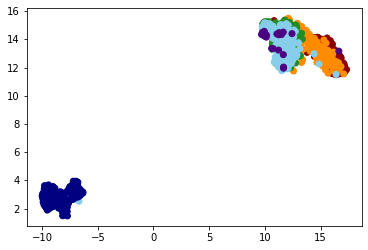

In [110]:
plt.scatter(umap_proj.T[0], umap_proj.T[1], c=colores)

In [86]:
umap.shape

(1000, 2)

In [160]:
rd[['PC_1', 'PC_2', 'PC_3']].to_csv('tables/pc3_rd.tab.gz', sep='\t', index=True, header=True)

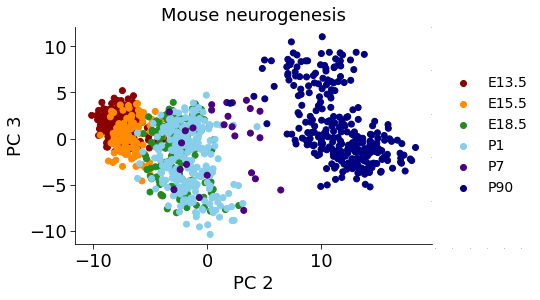

In [9]:

meta = pd.read_csv('../SraRunTable.txt.gz', index_col=0)

from matplotlib import pyplot as plt
colores = []
for cell in meta.loc[rd.index].Age:
    if cell == 'embryonic day 13.5':
        colores.append('darkred')
    if cell == 'embryonic day 15.5':
        colores.append('darkorange')
    if cell == 'embryonic day 18.5':
        colores.append('forestgreen')
    if cell == 'postnatal day 1':
        colores.append('skyblue')
    if cell == 'postnatal day 7':
        colores.append('indigo')
    if cell == 'postnatal day 90':
        colores.append('navy')
        
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8, 4))
gs = GridSpec(1,5)
gs.update(wspace=0.05, hspace=0.10)
ax = fig.add_subplot(gs[0,0:4])
ax_2 = fig.add_subplot(gs[0,4])
ax.scatter(rd.PC_1, rd.PC_3, c=colores)
ax.tick_params(labelsize=18, length=5)
ax.set_title('Mouse neurogenesis', fontsize=18)
ax.set_xlabel('PC 2', fontsize=18)
ax.set_ylabel('PC 3', fontsize=18)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax_2.scatter([-1], [0], c='darkred', label='E13.5')
ax_2.scatter([0], [0], c='darkorange', label='E15.5')
ax_2.scatter([0], [0], c='forestgreen', label='E18.5')
ax_2.scatter([0], [0], c='skyblue', label='P1')
ax_2.scatter([0], [0], c='indigo', label='P7')
ax_2.scatter([0], [0], c='navy', label='P90')
ax_2.spines["right"].set_visible(False)
ax_2.spines["top"].set_visible(False)
ax_2.spines["bottom"].set_visible(False)
ax_2.spines["left"].set_visible(False)
ax_2.tick_params(labelsize=0, length=0, which='both')
ax_2.set_xlim([2, 3])
ax_2.set_ylim([2, 3])
ax_2.legend(frameon=False, fontsize=14, loc='center left')

# plt.savefig('../../plots/PCA_neurogenesis.png', bbox_inches='tight', res=100)
# plt.savefig('../../plots/PCA_neurogenesis.svg', bbox_inches='tight')
# plt.savefig('../../plots/PCA_neurogenesis.pdf', bbox_inches='tight')

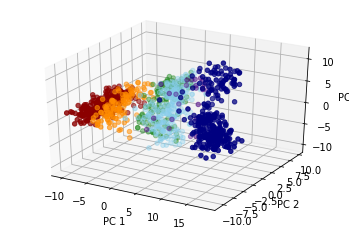

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100

ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c=colores)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

plt.show()

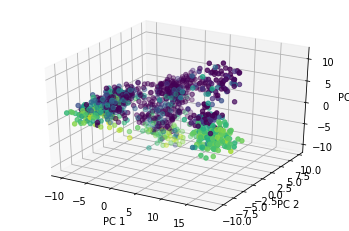

In [219]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100

ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c=norm_tpm_neuro.loc['Nxph4'])

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

plt.show()

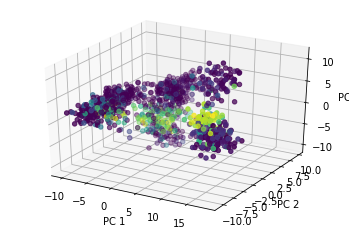

In [220]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100

ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c=norm_tpm_neuro.loc['Gad2'])

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

plt.show()

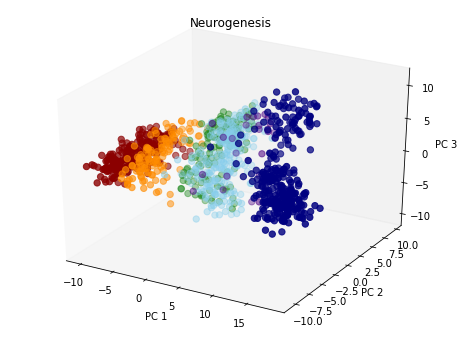

In [14]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.grid(False)

ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c=colores, s=40)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('Neurogenesis')

plt.show()

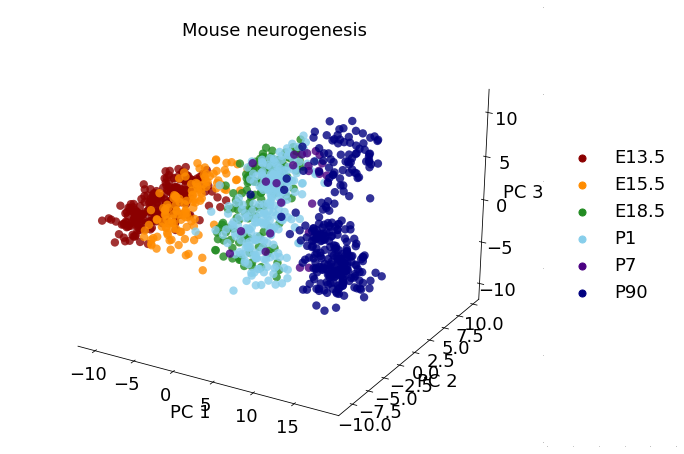

In [29]:

meta = pd.read_csv('../SraRunTable.txt.gz', index_col=0)

from matplotlib import pyplot as plt
colores = []
for cell in meta.loc[rd.index].Age:
    if cell == 'embryonic day 13.5':
        colores.append('darkred')
    if cell == 'embryonic day 15.5':
        colores.append('darkorange')
    if cell == 'embryonic day 18.5':
        colores.append('forestgreen')
    if cell == 'postnatal day 1':
        colores.append('skyblue')
    if cell == 'postnatal day 7':
        colores.append('indigo')
    if cell == 'postnatal day 90':
        colores.append('navy')
        
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(12, 8))
gs = GridSpec(1,5)
gs.update(wspace=0.05, hspace=0.10)
ax = fig.add_subplot(gs[0,0:4], projection='3d')
ax_2 = fig.add_subplot(gs[0,4])
ax.grid(False)
ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c=colores, s=70, linewidth=0, alpha=0.8)
# ax.scatter(rd.PC_1, rd.PC_3, c=colores)
ax.tick_params(labelsize=18, length=5)
ax.set_title('Mouse neurogenesis', fontsize=18)
ax.set_xlabel('PC 1', fontsize=18)
ax.set_ylabel('PC 2', fontsize=18)
ax.set_zlabel('PC 3', fontsize=18)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)


ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')


ax_2.scatter([-1], [0], c='darkred', label='E13.5', s=50)
ax_2.scatter([0], [0], c='darkorange', label='E15.5', s=50)
ax_2.scatter([0], [0], c='forestgreen', label='E18.5', s=50)
ax_2.scatter([0], [0], c='skyblue', label='P1', s=50)
ax_2.scatter([0], [0], c='indigo', label='P7', s=50)
ax_2.scatter([0], [0], c='navy', label='P90', s=50)
ax_2.spines["right"].set_visible(False)
ax_2.spines["top"].set_visible(False)
ax_2.spines["bottom"].set_visible(False)
ax_2.spines["left"].set_visible(False)
ax_2.tick_params(labelsize=0, length=0, which='both')
ax_2.set_xlim([2, 3])
ax_2.set_ylim([2, 3])
ax_2.legend(frameon=False, fontsize=18, loc='center left')

# plt.savefig('../../plots/PCA_neurogenesis.png', bbox_inches='tight', res=100)
# plt.savefig('../../plots/PCA_neurogenesis.svg', bbox_inches='tight')
# plt.savefig('../../plots/PCA_neurogenesis.pdf', bbox_inches='tight')

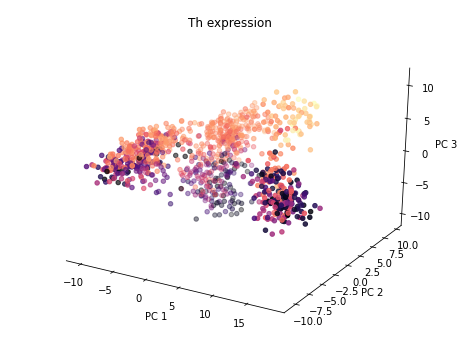

In [27]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.grid(False)

ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c=norm_tpm_neuro.loc['Th'], cmap='magma')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('Th expression')

plt.show()

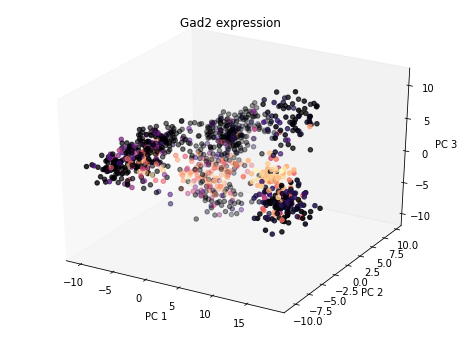

In [223]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.grid(False)

ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c=norm_tpm_neuro.loc['Gad2'], cmap='magma')

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('Gad2 expression')

plt.show()

NameError: name 'rd' is not defined

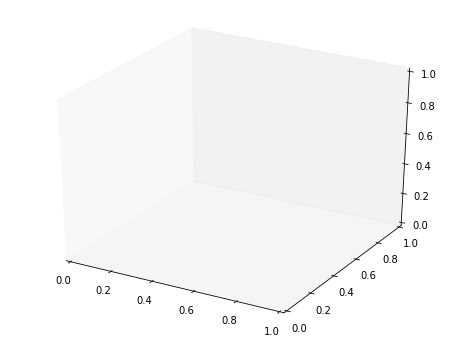

In [89]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.grid(False)

ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c=norm_tpm_neuro.loc['Aldh1a1'], cmap='magma')

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('Nxph4 expression')

plt.show()

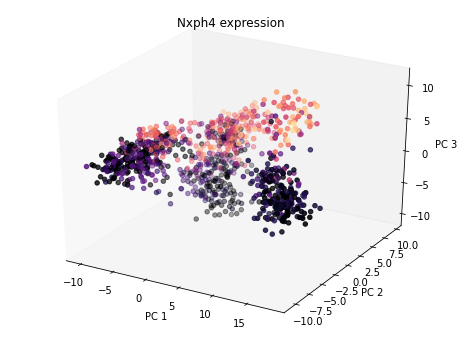

In [226]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.grid(False)

ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c=norm_tpm_neuro.loc['Slc6a3'], cmap='magma')

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('Nxph4 expression')

plt.show()

In [210]:
high_expression = norm_tpm.index[norm_tpm.mean(axis=1) > 0.1]
fano = (norm_tpm.loc[high_expression].var(axis=1)/norm_tpm.loc[high_expression].mean(axis=1)).sort_values()
pca_norm_tiklova = PCA(n_components=30)

scaled_counts = pd.DataFrame(StandardScaler().fit_transform(norm_tpm.loc[fano.index[-1000:]].T).T,
                             index = fano.index[-1000:], columns = norm_tpm.columns)

# pca_norm_tiklova = pca_norm_tiklova.fit(norm_tpm.loc[var_genes & norm_tpm.index].T)

# pca_norm_tiklova = pca_norm_tiklova.fit_transform(norm_tpm.loc[var_genes & norm_tpm.index].T)

pca_norm_tiklova = pca_norm_tiklova.fit_transform(scaled_counts.T)


rd = pd.DataFrame()
for i in range(30):
    rd['PC_' + str(i+1)] = pca_norm_tiklova.T[i]

rd.index = norm_tpm.columns
rd.PC_2 = - rd.PC_2


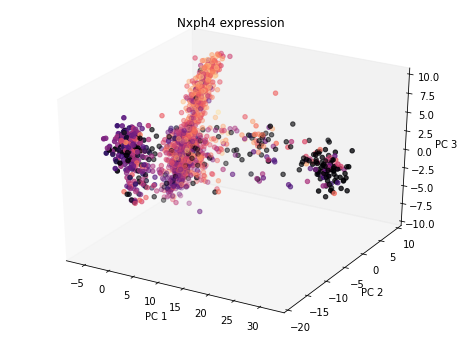

In [216]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.grid(False)

ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c=norm_tpm.loc['Rbfox2'], cmap='magma')

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('Nxph4 expression')

plt.show()

In [8]:
g = []
for row in cell_metric[0]:
    for i in range(1, len(row)):
        g.append((row[0], row[i]))
    
graph = ig.Graph(g)

In [9]:
graph

In [14]:
from igraph import *
layout = graph.layout("kk")
plot(graph, layout = layout, vertex_size=10, vertex_color=norm_tpm_neuro.loc['Cck', rd.index])

ValueError: palette index used when no palette was given

In [22]:
!pip install cairocffi

     |████████████████████████████████| 70 kB 1.8 MB/s  eta 0:00:01
  Created wheel for cairocffi: filename=cairocffi-1.2.0-py3-none-any.whl size=89545 sha256=58c846445b60032b0a00ea4576bf4e8071df4cf7b6e9970a7f34c14e88907eba
  Stored in directory: /mnt/lareaulab/cfbuenabadn/.cache/pip/wheels/e2/ca/86/9db2824f203afe4bdf5aa6ead017f352fcc90e92f095b78871
Successfully built cairocffi
